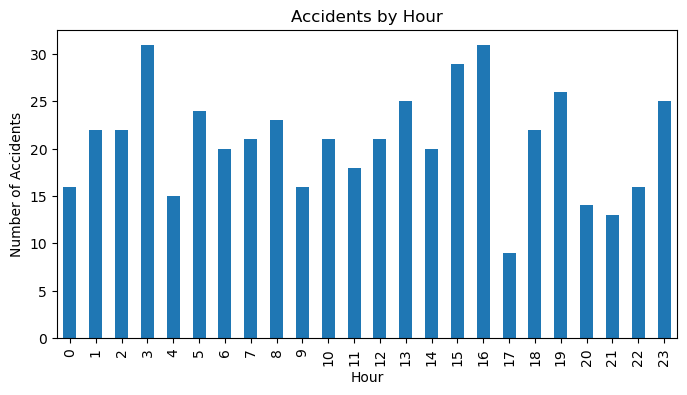

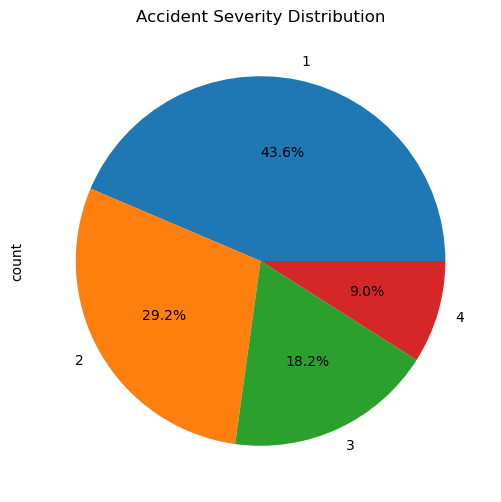

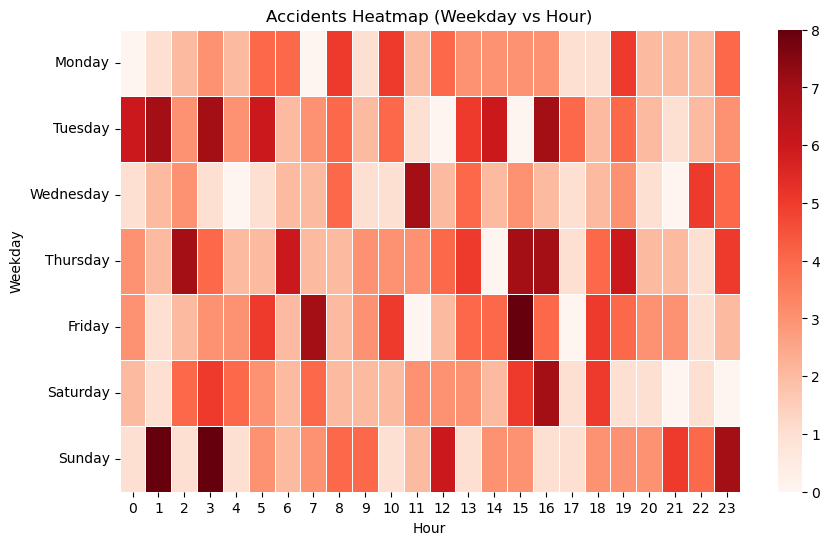

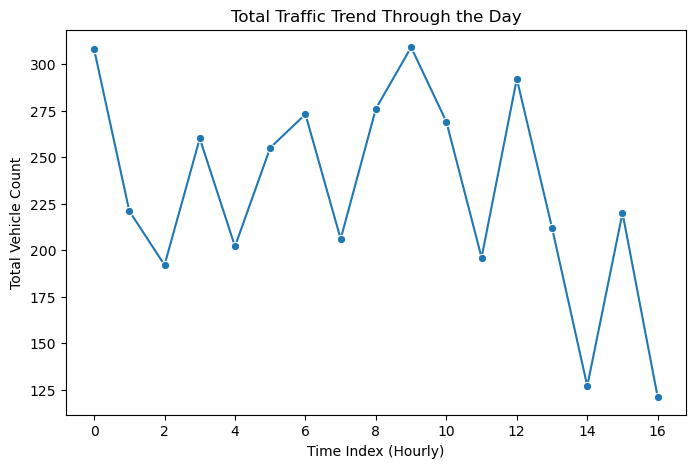

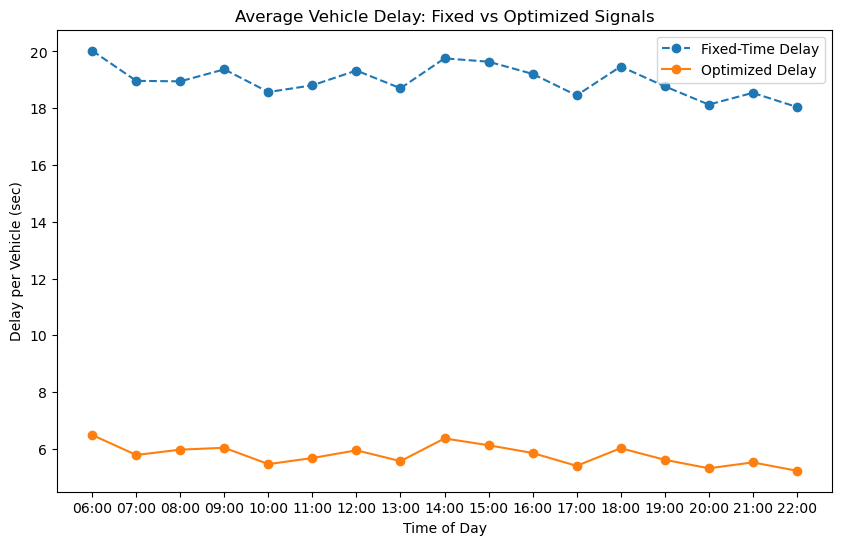

=== Logistic Regression ===
Accuracy: 0.24
              precision    recall  f1-score   support

           1       0.65      0.23      0.34        48
           2       0.30      0.39      0.34        28
           3       0.17      0.06      0.08        18
           4       0.03      0.17      0.04         6

    accuracy                           0.24       100
   macro avg       0.28      0.21      0.20       100
weighted avg       0.43      0.24      0.27       100

Confusion Matrix:
 [[11 17  2 18]
 [ 3 11  2 12]
 [ 2  6  1  9]
 [ 1  3  1  1]]

=== Decision Tree ===
Accuracy: 0.47
              precision    recall  f1-score   support

           1       0.51      0.77      0.62        48
           2       0.32      0.25      0.28        28
           3       0.75      0.17      0.27        18
           4       0.00      0.00      0.00         6

    accuracy                           0.47       100
   macro avg       0.40      0.30      0.29       100
weighted avg       0.47 

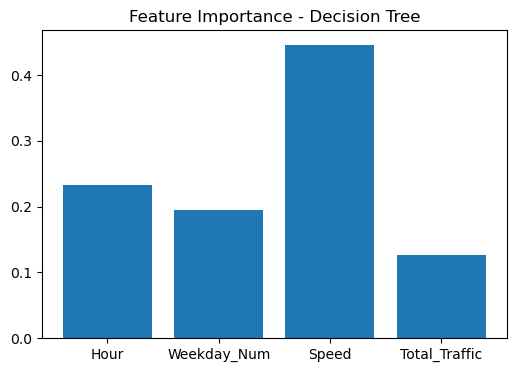

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =========================
# 1. Load & Clean Data
# =========================
file = "traffic_data.xlsx"
accidents = pd.read_excel(file, sheet_name="Accidents")
counts = pd.read_excel(file, sheet_name="Counts")

# Convert datetime
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])
accidents['Hour'] = accidents['Start_Time'].dt.hour
accidents['Weekday'] = accidents['Start_Time'].dt.day_name()

counts['Hour'] = pd.to_datetime(counts['Time'], format='%H:%M').dt.hour
counts['Total_Traffic'] = counts[["Cars", "Buses", "Trucks", "TwoWheelers"]].sum(axis=1)

# =========================
# 2. Exploratory Data Analysis (EDA)
# =========================
plt.figure(figsize=(8,4))
accidents['Hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Accidents by Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.show()

accidents['Severity'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Accident Severity Distribution")
plt.show()

heatmap_data = accidents.groupby(['Weekday', 'Hour']).size().unstack(fill_value=0)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5)
plt.title("Accidents Heatmap (Weekday vs Hour)")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(len(counts)), y=counts["Total_Traffic"], marker="o")
plt.title("Total Traffic Trend Through the Day")
plt.xlabel("Time Index (Hourly)")
plt.ylabel("Total Vehicle Count")
plt.show()

# =========================
# 3. Traffic Signal Optimization
# =========================
saturation_flow = 1800
lanes_A = 2
lanes_B = 1
lost_time = 8

optimized_A, optimized_B = [], []
fixed_A, fixed_B = [], []
cycle_lengths = []

for i, row in counts.iterrows():
    vehicles_A = row["Cars"] + row["Buses"]
    vehicles_B = row["Trucks"] + row["TwoWheelers"]

    yA = vehicles_A / (saturation_flow * lanes_A)
    yB = vehicles_B / (saturation_flow * lanes_B)
    Y = yA + yB

    C_opt = (1.5 * lost_time + 5) / (1 - Y) if Y < 1 else 120
    gA = (yA / Y) * (C_opt - lost_time)
    gB = (yB / Y) * (C_opt - lost_time)

    optimized_A.append(gA)
    optimized_B.append(gB)
    cycle_lengths.append(C_opt)

    fixed_A.append((120 - lost_time)/2)
    fixed_B.append((120 - lost_time)/2)

counts["Opt_A"] = optimized_A
counts["Opt_B"] = optimized_B
counts["Fixed_A"] = fixed_A
counts["Fixed_B"] = fixed_B
counts["Cycle"] = cycle_lengths

def calculate_delay(flow, lanes, sat_flow, g, C):
    s = sat_flow * lanes
    v = flow
    g_C = g / C
    X = v / (s * g_C) if g_C > 0 else 1
    if X >= 1:
        return 999
    else:
        return (0.5 * C * (1 - g_C)**2) / (1 - min(1,X))

delay_opt, delay_fixed = [], []

for i, row in counts.iterrows():
    vehicles_A = row["Cars"] + row["Buses"]
    vehicles_B = row["Trucks"] + row["TwoWheelers"]

    dA_opt = calculate_delay(vehicles_A, lanes_A, saturation_flow, row["Opt_A"], row["Cycle"])
    dB_opt = calculate_delay(vehicles_B, lanes_B, saturation_flow, row["Opt_B"], row["Cycle"])
    delay_opt.append(np.mean([dA_opt, dB_opt]))

    g_fixed = (120 - lost_time)/2
    dA_fixed = calculate_delay(vehicles_A, lanes_A, saturation_flow, g_fixed, 120)
    dB_fixed = calculate_delay(vehicles_B, lanes_B, saturation_flow, g_fixed, 120)
    delay_fixed.append(np.mean([dA_fixed, dB_fixed]))

counts["Delay_Opt"] = delay_opt
counts["Delay_Fixed"] = delay_fixed
counts["Improvement_%"] = ((counts["Delay_Fixed"] - counts["Delay_Opt"])/counts["Delay_Fixed"])*100

plt.figure(figsize=(10,6))
plt.plot(counts["Time"], counts["Delay_Fixed"], linestyle="--", marker="o", label="Fixed-Time Delay")
plt.plot(counts["Time"], counts["Delay_Opt"], marker="o", label="Optimized Delay")
plt.title("Average Vehicle Delay: Fixed vs Optimized Signals")
plt.xlabel("Time of Day")
plt.ylabel("Delay per Vehicle (sec)")
plt.legend()
plt.show()

# =========================
# 4. Accident Risk Prediction
# =========================
data = accidents.merge(counts[['Hour','Total_Traffic']], on='Hour', how='left')
data['Weekday_Num'] = data['Weekday'].map({
    'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,
    'Friday':4,'Saturday':5,'Sunday':6
})

X = data[['Hour','Weekday_Num','Speed','Total_Traffic']].copy()
y = data['Severity'].astype(int)

# Fill missing values correctly
for col in ['Speed','Total_Traffic']:
    X[col] = X[col].fillna(X[col].median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with class_weight='balanced'
log_model = LogisticRegression(max_iter=500, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("\n=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

# Feature Importance
importances = tree_model.feature_importances_
plt.figure(figsize=(6,4))
plt.bar(X.columns, importances)
plt.title("Feature Importance - Decision Tree")
plt.show()
